In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score 
from sklearn.ensemble import RandomForestClassifier 
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, plot_precision_recall_curve, roc_auc_score
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

# Some data preprocessing

In [2]:
url = 'https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv'
data = pd.read_csv(url)

In [3]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
data2 = data.copy()
robust = RobustScaler()
data_robust = robust.fit_transform(data2)

In [10]:
robust_df = pd.DataFrame(data_robust, index = data2.index, columns = data2.columns)
robust_df['Class'] = data['Class']

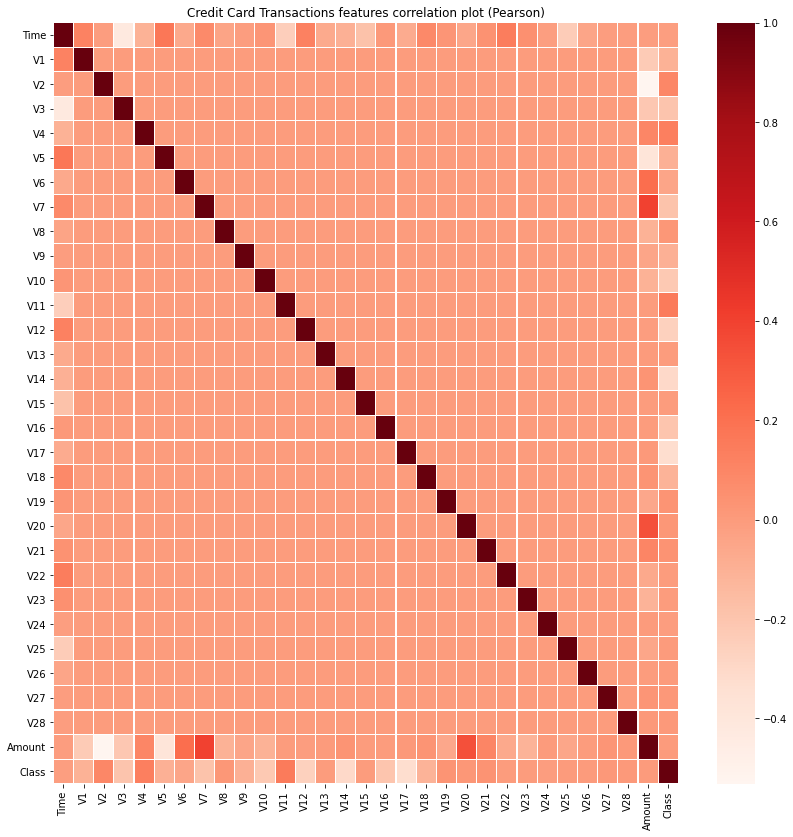

In [201]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

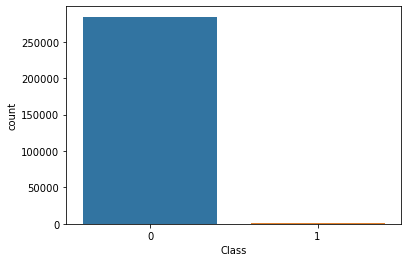

In [12]:
sns.countplot(data['Class'])

In [13]:
y1 = data['Class']
X1 = robust_df.drop(['Class'], axis = 1)

In [14]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

# Logistic regression on original dataset with default hyperparameters


In [15]:
logistic_def = LogisticRegression(max_iter = 500) # Tunin LR with default hyperparameters. I increased maximum iterations from 100 to 500 for better learning 
logistic_def.fit(X1_train, y1_train)


LogisticRegression(max_iter=500)

In [16]:
result = cross_val_score(logistic_def, X1_train, y1_train, cv = 5, n_jobs = -1).mean() 
log_def_score = cross_val_predict(logistic_def, X1_train, y1_train, cv = 5, n_jobs = -1)# Prediction on cross validation with 5 folds


In [17]:
print(f'''Result is {result},
Precision is {precision_score(log_def_score, y1_train)},
Recall is {recall_score(log_def_score, y1_train)},
Confusion matrix is {confusion_matrix(log_def_score, y1_train)},
MCC : {matthews_corrcoef(y1_train, log_def_score)},
Classification report: {classification_report(y1_train, log_def_score)}
''')

Result is 0.9992187671443306,
Precision is 0.6269035532994924,
Recall is 0.8884892086330936,
Confusion matrix is [[227420    147]
 [    31    247]],
MCC : 0.745969890933559,
Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.89      0.63      0.74       394

    accuracy                           1.00    227845
   macro avg       0.94      0.81      0.87    227845
weighted avg       1.00      1.00      1.00    227845




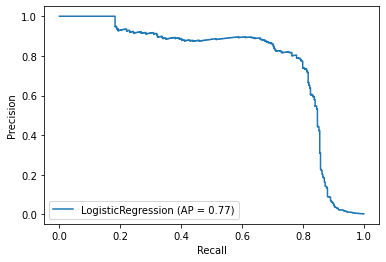

In [18]:
disp = plot_precision_recall_curve(logistic_def, X1_train, y1_train) # Average Precision = 0.77

In [19]:
roc_auc_score(y1_train, log_def_score)

0.8133836301038968

# Logistic regression with ADASYN

In [20]:
ada = ADASYN(random_state=42)
X_adasyn, y_adasyn = ada.fit_resample(X1_train, y1_train) # oversample minority class such that dataset's classes proprotion equal to 50/50 for both class

In [21]:
logistic_adasyn = LogisticRegression(random_state = 42, max_iter = 500)

In [22]:
logistic_adasyn.fit(X_adasyn, y_adasyn) # Training LR on oversampled data 

LogisticRegression(max_iter=500, random_state=42)

In [23]:
y_pred_adasyn = cross_val_predict(logistic_adasyn, X1_train, y1_train, cv = 5)

In [24]:
print(f'''
Precision score: {precision_score(y1_train, y_pred_adasyn)},
Recall score: {recall_score(y1_train, y_pred_adasyn)},
Confusion matrix: {confusion_matrix(y1_train, y_pred_adasyn)},
MCC : {matthews_corrcoef(y1_train, y_pred_adasyn)},
Classification report: {classification_report(y1_train, y_pred_adasyn)}''')


Precision score: 0.8897058823529411,
Recall score: 0.6142131979695431,
Confusion matrix: [[227421     30]
 [   152    242]],
MCC : 0.7388786033224832,
Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.89      0.61      0.73       394

    accuracy                           1.00    227845
   macro avg       0.94      0.81      0.86    227845
weighted avg       1.00      1.00      1.00    227845



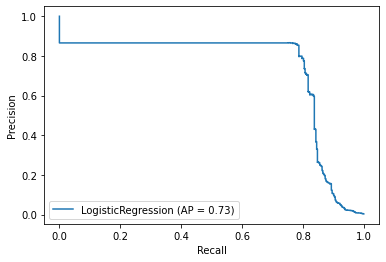

In [25]:
disp2 = plot_precision_recall_curve(logistic_adasyn, X1_train, y1_train)

In [26]:
roc_auc_score(y1_train, y_pred_adasyn)

0.8070406507145946

In [27]:
cross_val_score(logistic_adasyn, X1_train, y1_train, cv = 5, n_jobs = -1, scoring = "accuracy")

array([0.99927582, 0.9991661 , 0.99920999, 0.99910027, 0.99934166])

# Logistic regression with class weight 

In [28]:
w = sum(y1_train == 0) / sum(y1_train == 1)

logistic_weight = LogisticRegression(class_weight = {0 : 1, 1 : w}, random_state = 42, max_iter = 500)

logistic_weight.fit(X1_train, y1_train)

LogisticRegression(class_weight={0: 1, 1: 577.2868020304569}, max_iter=500,
                   random_state=42)

In [29]:
y_pred_weight = cross_val_predict(logistic_weight, X1_train, y1_train, cv = 10, n_jobs = -1)

In [30]:
cross_val_score(logistic_weight, X1_train, y1_train, cv = 10, n_jobs = -1, scoring = 'recall').mean()

0.9066025641025641

In [31]:
print(f'''
Precision score: {precision_score(y1_train, y_pred_weight)},
Recall score: {recall_score(y1_train, y_pred_weight)},
Confusion matrix: {confusion_matrix(y1_train, y_pred_weight)},
MCC : {matthews_corrcoef(y1_train, y_pred_weight)},
Classification report: {classification_report(y1_train, y_pred_weight)}''')


Precision score: 0.06281893366179835,
Recall score: 0.9060913705583756,
Confusion matrix: [[222125   5326]
 [    37    357]],
MCC : 0.2351631736187096,
Classification report:               precision    recall  f1-score   support

           0       1.00      0.98      0.99    227451
           1       0.06      0.91      0.12       394

    accuracy                           0.98    227845
   macro avg       0.53      0.94      0.55    227845
weighted avg       1.00      0.98      0.99    227845



In [32]:
roc_auc_score(y1_train, y_pred_weight)

0.9413376690471201

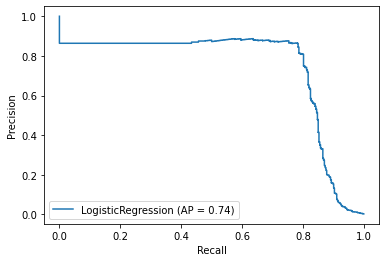

In [33]:
disp3 = plot_precision_recall_curve(logistic_weight, X1_train, y1_train)

# Visualisation of data with DBSCAN

In [34]:
db = DBSCAN(eps=0.4, min_samples=20) # Hyperparameters: distance between two points = 0.4 and minimal samples in neghborhood = 20

In [35]:
db.fit(X1_train)

DBSCAN(eps=0.4, min_samples=20)

In [36]:
y_pred_dbscan = db.fit_predict(X1_train)

In [37]:
def dbscan(X, eps, min_samples):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")

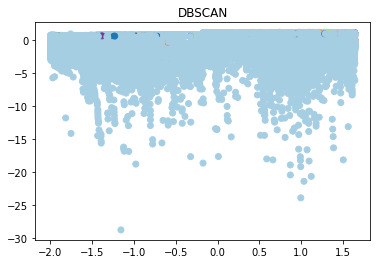

In [38]:
dbscan(X1_train, eps = 0.4, min_samples = 20) # Based on density we can conclude that fraud's behavior similar to legitimate transaction behavior

# Random Forest with class weight

In [39]:
w = sum(y1_train == 0) / sum(y1_train == 1)

RF = RandomForestClassifier(class_weight={0: 1, 1: w}, random_state = 42, n_jobs = -1, n_estimators = 500, max_depth = 10)
# Max_depth = 10 tuned for avoiding overfitting and n_estimator = 500 for to train more trees 

In [40]:
RF.fit(X1_train, y1_train)

RandomForestClassifier(class_weight={0: 1, 1: 577.2868020304569}, max_depth=10,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [41]:
y_pred_RF = cross_val_predict(RF, X1_train, y1_train, cv = 5, n_jobs = -1)

In [42]:
print(f'''
Precision score: {precision_score(y1_train, y_pred_RF)},
Recall score: {recall_score(y1_train, y_pred_RF)},
Confusion matrix: {confusion_matrix(y1_train, y_pred_RF)},
MCC : {matthews_corrcoef(y1_train, y_pred_RF)},
Classification report: {classification_report(y1_train, y_pred_RF)}''')


Precision score: 0.8646408839779005,
Recall score: 0.7944162436548223,
Confusion matrix: [[227402     49]
 [    81    313]],
MCC : 0.8285020827766065,
Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.86      0.79      0.83       394

    accuracy                           1.00    227845
   macro avg       0.93      0.90      0.91    227845
weighted avg       1.00      1.00      1.00    227845



In [43]:
cross_val_score(RF, X1_train, y1_train, cv = 5, n_jobs = -1, scoring = 'accuracy').mean()

0.9994294366784437

In [44]:
roc_auc_score(y1_train, y_pred_RF)

0.8971004063194556

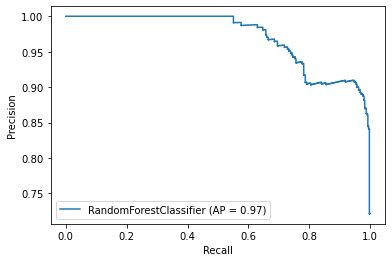

In [45]:
disp4 = plot_precision_recall_curve(RF, X1_train, y1_train)

# Random Forest with imbalanced data

In [179]:
RF2 = RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators = 500, max_depth = 15)
RF2.fit(X1_train, y1_train)
# Here I randomly (Միամիտ) tuned max_depth = 15, because of long training time I didn't change this hyperparameter
# but there is a no much difference between max_depth = 15 or 10 

RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [180]:
y_pred_RF2 = cross_val_predict(RF2, X1_train, y1_train, cv = 5, n_jobs = -1)
print(f'''
Precision score: {precision_score(y1_train, y_pred_RF2)},
Recall score: {recall_score(y1_train, y_pred_RF2)},
Confusion matrix: {confusion_matrix(y1_train, y_pred_RF2)},
MCC : {matthews_corrcoef(y1_train, y_pred_RF2)},
Classification report: {classification_report(y1_train, y_pred_RF2)}''')


Precision score: 0.9409937888198758,
Recall score: 0.7690355329949239,
Confusion matrix: [[227432     19]
 [    91    303]],
MCC : 0.8504537052661266,
Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.94      0.77      0.85       394

    accuracy                           1.00    227845
   macro avg       0.97      0.88      0.92    227845
weighted avg       1.00      1.00      1.00    227845



In [48]:
roc_auc_score(y1_train, y_pred_RF2)

0.8844759992596831

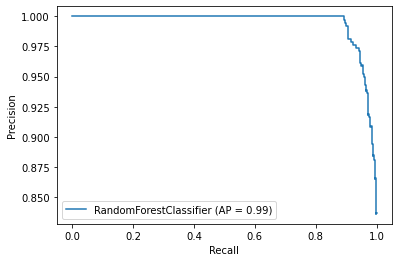

In [49]:
disp5 = plot_precision_recall_curve(RF2, X1_train, y1_train)

# Random forest with ADASYN

In [50]:
ada_forest = ADASYN(random_state=42)
X_ada_forest, y_ada_forest = ada_forest.fit_resample(X1_train, y1_train)

In [51]:
X_ada_forest.shape

(454886, 30)

In [52]:
y_ada_forest.shape

(454886,)

In [53]:
print('Resampled dataset shape %s' % Counter(y_ada_forest))

Resampled dataset shape Counter({0: 227451, 1: 227435})


In [54]:
RF_adasyn = RandomForestClassifier(random_state = 42, n_jobs = -1, n_estimators = 500, max_depth = 10)
RF_adasyn.fit(X_ada_forest, y_ada_forest)


RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [55]:
y3_pred = cross_val_predict(RF_adasyn, X1_train, y1_train, cv = 5, n_jobs = -1)

In [56]:
print(f'''
Precision: {precision_score(y1_train, y3_pred)},
Recall: {recall_score(y1_train, y3_pred)},
Confusion: {confusion_matrix(y1_train, y3_pred)},
MCC: {matthews_corrcoef(y1_train, y3_pred)},
Classific report: {classification_report(y1_train, y3_pred)}''')


Precision: 0.9435736677115988,
Recall: 0.7639593908629442,
Confusion: [[227433     18]
 [    93    301]],
MCC: 0.8488021324840862,
Classific report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.94      0.76      0.84       394

    accuracy                           1.00    227845
   macro avg       0.97      0.88      0.92    227845
weighted avg       1.00      1.00      1.00    227845



In [57]:
roc_auc_score(y1_train, y3_pred)

0.8819401264693659

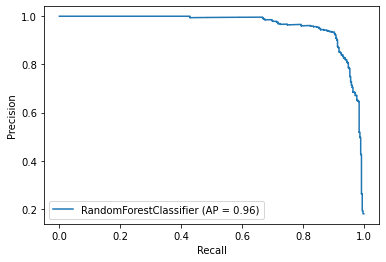

In [58]:
disp6 = plot_precision_recall_curve(RF_adasyn, X1_train, y1_train)

# LightGBM with imbalanced data 

In [175]:
lgbm = LGBMClassifier(n_jobs = -1, num_leaves = 100, learning_rate = 0.05, max_depth = 10) #Because of fast training time I 
#tried tune model with some hyperparameters and choose the best one for future modelling

In [176]:
lgbm.fit(X1_train, y1_train)

LGBMClassifier(learning_rate=0.05, max_depth=10, num_leaves=100)

In [177]:
y_pred_lgbm = cross_val_predict(lgbm, X1_train, y1_train, cv = 5, n_jobs = -1)

In [178]:
print(f'''
Precision: {precision_score(y1_train, y_pred_lgbm)},
Recall: {recall_score(y1_train, y_pred_lgbm)},
Confusion: {confusion_matrix(y1_train, y_pred_lgbm)},
MCC: {matthews_corrcoef(y1_train, y_pred_lgbm)},
Classific report: {classification_report(y1_train, y_pred_lgbm)}''')


Precision: 0.600451467268623,
Recall: 0.6751269035532995,
Confusion: [[227274    177]
 [   128    266]],
MCC: 0.6360299501273342,
Classific report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.60      0.68      0.64       394

    accuracy                           1.00    227845
   macro avg       0.80      0.84      0.82    227845
weighted avg       1.00      1.00      1.00    227845



In [181]:
roc_auc_score(y1_train, y_pred_lgbm)

0.8371743569826061

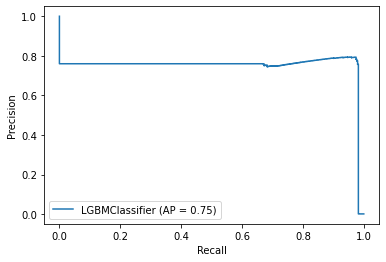

In [182]:
disp_ = plot_precision_recall_curve(lgbm, X1_train, y1_train)

In [115]:
lgbm2 = LGBMClassifier(random_state = 42, n_jobs = -1, 
                       num_leaves = 1000, learning_rate = 0.1, max_depth = 10) 

In [116]:
lgbm2.fit(X1_train, y1_train)

LGBMClassifier(max_depth=10, num_leaves=1000, random_state=42)

In [117]:
y_pred_lgbm2 = cross_val_predict(lgbm2, X1_train, y1_train, cv = 5, n_jobs = -1)

In [118]:
print(f'''
Precision: {precision_score(y1_train, y_pred_lgbm2)},
Recall: {recall_score(y1_train, y_pred_lgbm2)},
Confusion: {confusion_matrix(y1_train, y_pred_lgbm2)},
MCC: {matthews_corrcoef(y1_train, y_pred_lgbm2)},
Classific report: {classification_report(y1_train, y_pred_lgbm2)}''')


Precision: 0.2616580310880829,
Recall: 0.5126903553299492,
Confusion: [[226881    570]
 [   192    202]],
MCC: 0.36477725001398287,
Classific report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.26      0.51      0.35       394

    accuracy                           1.00    227845
   macro avg       0.63      0.76      0.67    227845
weighted avg       1.00      1.00      1.00    227845



In [123]:
lgbm3 = LGBMClassifier(random_state = 42, n_jobs = -1, 
                       num_leaves = 70, learning_rate = 0.1, max_depth = 10) 

In [124]:
lgbm3.fit(X1_train, y1_train)

LGBMClassifier(max_depth=10, num_leaves=70, random_state=42)

In [125]:
y_pred_lgbm3 = cross_val_predict(lgbm3, X1_train, y1_train, cv = 5, n_jobs = -1)

In [126]:
print(f'''
Precision: {precision_score(y1_train, y_pred_lgbm3)},
Recall: {recall_score(y1_train, y_pred_lgbm3)},
Confusion: {confusion_matrix(y1_train, y_pred_lgbm3)},
MCC: {matthews_corrcoef(y1_train, y_pred_lgbm3)},
Classific report: {classification_report(y1_train, y_pred_lgbm3)}''')


Precision: 0.23182957393483708,
Recall: 0.46954314720812185,
Confusion: [[226838    613]
 [   209    185]],
MCC: 0.3283282607892739,
Classific report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.23      0.47      0.31       394

    accuracy                           1.00    227845
   macro avg       0.62      0.73      0.65    227845
weighted avg       1.00      1.00      1.00    227845



# LightGBM with class weight

In [155]:
w = sum(y1_train == 0) / sum(y1_train == 1)

weight = {0 : 1, 1: w}

In [156]:
lgbm_class_weight = LGBMClassifier(random_state = 42, n_jobs = -1, num_leaves = 100, max_depth = 10, class_weight = weight)

In [158]:
lgbm_class_weight.fit(X1_train, y1_train)

LGBMClassifier(class_weight={0: 1, 1: 577.2868020304569}, max_depth=10,
               num_leaves=100, random_state=42)

In [159]:
y_pred_class_weight = cross_val_predict(lgbm_class_weight, X1_train, y1_train, cv = 5, n_jobs = -1)

In [162]:
print(f'''
Precision: {precision_score(y1_train, y_pred_class_weight)},
Recall: {recall_score(y1_train, y_pred_class_weight)},
Confusion matrix: {confusion_matrix(y1_train, y_pred_class_weight)},
MCC : {matthews_corrcoef(y1_train, y_pred_class_weight)},
Classification report: {classification_report(y1_train, y_pred_class_weight)}''')


Precision: 0.8962536023054755,
Recall: 0.7893401015228426,
Confusion matrix: [[227415     36]
 [    83    311]],
MCC : 0.8408442961226863,
Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.90      0.79      0.84       394

    accuracy                           1.00    227845
   macro avg       0.95      0.89      0.92    227845
weighted avg       1.00      1.00      1.00    227845



In [174]:
cross_val_score(lgbm_class_weight, X1_train, y1_train, scoring = 'recall', cv = 5).mean()

0.789451476793249

In [163]:
roc_auc_score(y1_train, y_pred_class_weight)

0.894590912837209

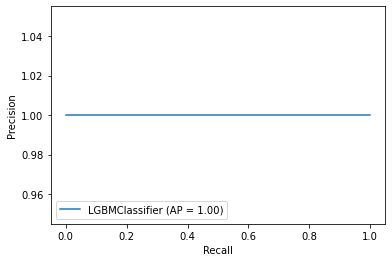

In [164]:
disp7 = plot_precision_recall_curve(lgbm_class_weight, X1_train, y1_train)

# LightGBM with ADASYN

In [165]:
adasyn_lgbm = ADASYN(random_state = 15)

In [166]:
X_adasyn_lgbm, y_adasyn_lgbm = adasyn_lgbm.fit_resample(X1_train, y1_train)

In [184]:
class_weight_lgbm = LGBMClassifier(num_leaves = 100, max_depth = 10, n_jobs  = -1)

In [185]:
class_weight_lgbm.fit(X_adasyn_lgbm, y_adasyn_lgbm)

LGBMClassifier(max_depth=10, num_leaves=100)

In [186]:
y_lgbm_ad = cross_val_predict(class_weight_lgbm, X1_train, y1_train, cv = 5, n_jobs = -1)

In [189]:
print(f'''
Precision: {precision_score(y1_train, y_lgbm_ad)},
Recall : {recall_score(y1_train, y_lgbm_ad)},
Confusion matrix: {confusion_matrix(y1_train, y_lgbm_ad)},
MCC : {matthews_corrcoef(y1_train, y_lgbm_ad)},
Classific. report: {classification_report(y1_train, y_lgbm_ad)}''')


Precision: 0.2593068035943517,
Recall : 0.5126903553299492,
Confusion matrix: [[226874    577]
 [   192    202]],
MCC : 0.3631183210193419,
Classific. report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.26      0.51      0.34       394

    accuracy                           1.00    227845
   macro avg       0.63      0.76      0.67    227845
weighted avg       1.00      1.00      1.00    227845



In [190]:
cross_val_score(class_weight_lgbm, X1_train, y1_train, scoring = 'recall', cv = 5).mean()

0.4849399545602077

In [191]:
roc_auc_score(y1_train, y_lgbm_ad)

0.7550767726019061

# LightGBM with class weight on test data 

In [192]:
prediction = lgbm_class_weight.predict(X1_test)

In [195]:
print(f'''
Precision: {precision_score(y1_test, prediction)},
Recall: {recall_score(y1_test, prediction)},
Confusion matrix: {confusion_matrix(y1_test, prediction)},
MCC: {matthews_corrcoef(y1_test, prediction)},
classification report: {classification_report(y1_test, prediction)}''')


Precision: 0.9746835443037974,
Recall: 0.7857142857142857,
Confusion matrix: [[56862     2]
 [   21    77]],
MCC: 0.8749276812909632,
classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [196]:
roc_auc_score(y1_test, prediction)

0.892839557038347

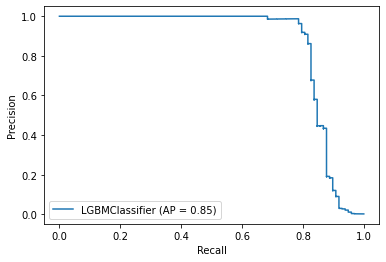

In [197]:
disp_result = plot_precision_recall_curve(lgbm_class_weight, X1_test, y1_test)

In [205]:
lgbm_class_weight.feature_importances_

array([335, 430, 273, 366, 470, 275, 196, 324, 292, 270, 411, 377, 484,
       308, 580, 255, 351, 341, 258, 368, 224, 292, 301, 184, 365, 212,
       426, 311, 229, 390])

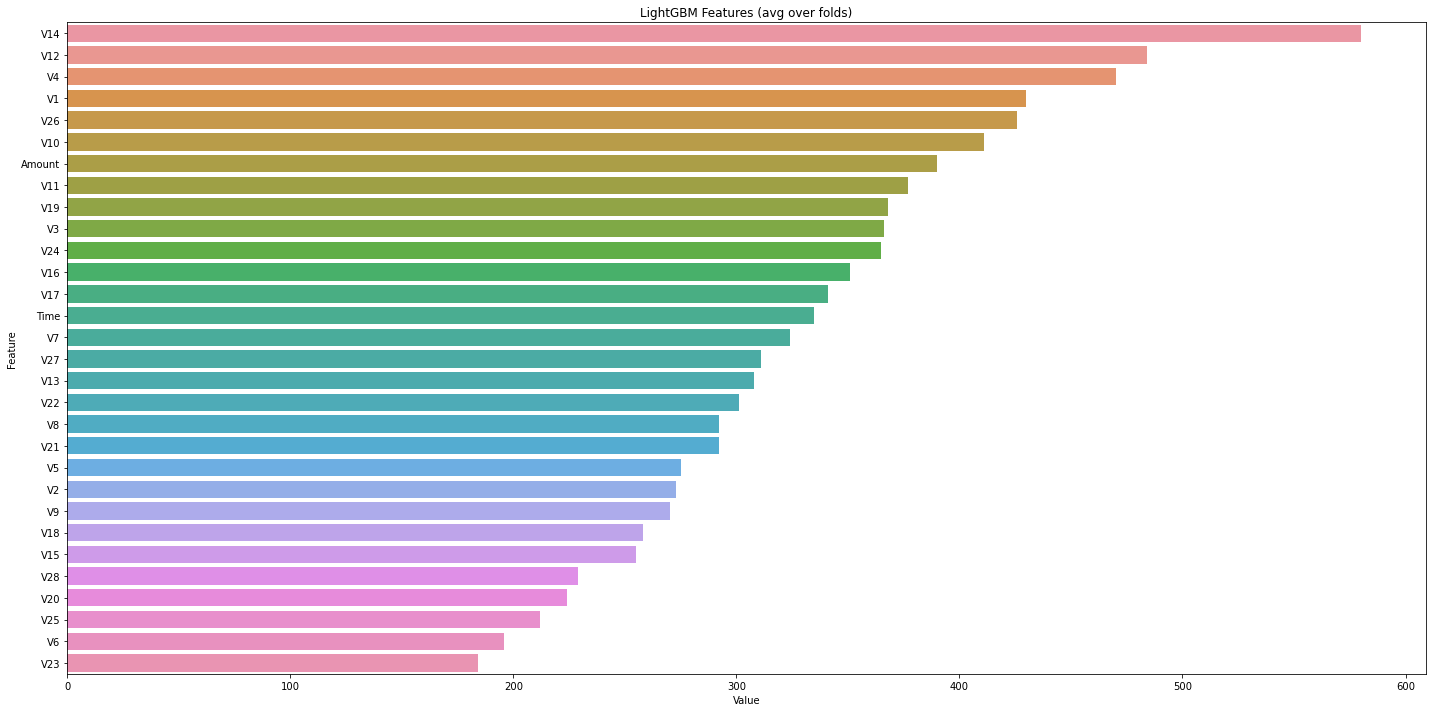

In [206]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_class_weight.feature_importances_, X1_test.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()